In [1]:
from keras.models import Model, load_model, model_from_json
import keras
from keras.datasets import cifar10, mnist
from keras import regularizers, callbacks
import sys
sys.path.append('C:/Users/320060820/Documents/prep_experiments/model_quantization')
from train_model import *
from inception_model import get_model
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
TRAIN = True
save_path = '../../saved models/'
num_classes = 10
epochs = 30
reduced_training_size_factor = 10
batch_size = 64

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

train_data, test_data = (x_train, y_train), (x_test, y_test)

kernels = [20, 16, 32, 64]
model = get_model(input_shape=(96, 96, 1), nb_classes=10, 
                          nb_fabrics=49, scale_factor=96//96, nb_inception_modules=3,
                          resampling='conv', kernels=kernels, reg=None, batch_norm=False, pool_layer='average')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 20)   200         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 48, 48, 16)   336         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 48, 16)   336         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (

In [4]:
train_data, test_data, trained_model, history = train_model(
                    model, train_data, test_data, epochs, 
                    batch_size, num_classes, reduced_training_size_factor, rgb=False)
trained_model.save(save_path + 'v3_no_batchnorm.h5')
x_train_resize, y_train = train_data
x_test_resize, y_test = test_data

Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - 9s 1ms/step - loss: 1.8793 - acc: 0.3063 - val_loss: 1.0052 - val_acc: 0.6580
Epoch 2/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6388 - acc: 0.8003 - val_loss: 0.5783 - val_acc: 0.8250
Epoch 3/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.3571 - acc: 0.8920 - val_loss: 0.5023 - val_acc: 0.8520
Epoch 4/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.2521 - acc: 0.9282 - val_loss: 0.3114 - val_acc: 0.9020
Epoch 5/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.1926 - acc: 0.9440 - val_loss: 0.2327 - val_acc: 0.9250
Epoch 6/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.1487 - acc: 0.9542 - val_loss: 0.2523 - val_acc: 0.9220
Epoch 7/30
6000/6000 [==============================] - 6s 1ms/step - loss: 0.1437 - acc: 0.9550 - v

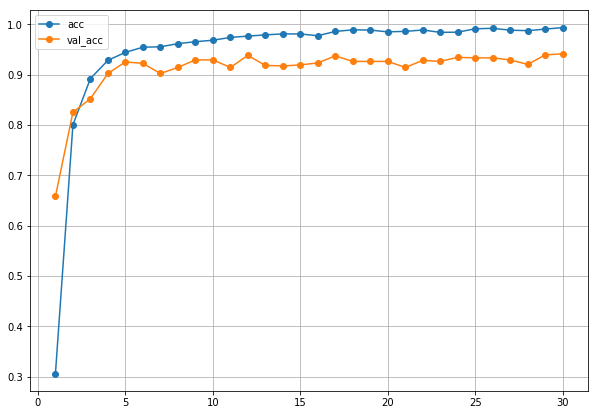

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, epochs+1), history.history['acc'], 'o-',label='acc')
plt.plot(np.arange(1, epochs+1), history.history['val_acc'], 'o-', label='val_acc')
plt.legend()
plt.grid()

Having removed BN, we find that the network overfits to a certain degree. Additionally the validation accuracy saturates around 94%. With BN, this accuracy goes upto 97 or even 98%. 

In [6]:
def get_weights_without_biases(model):
    """
    Get weights of the convolution layers excluding biases
    """
    weights_list = model.layers[1].get_weights()[0].flatten() # accesses all weights in the first convolutional layer
    for layer in model.layers[2:]:
        if layer.weights and 'kernel' in layer.weights[0].name:
            weights_list = np.append(weights_list, layer.get_weights()[0].flatten())
    
    return weights_list

In [ ]:
model_batchnorm = load_model(save_path + 'v3_original_model.h5')
ww = get_weights_without_biases(model_batchnorm)
w = get_weights_without_biases(trained_model)

Text(0.5, 1.0, 'With batch normalization')

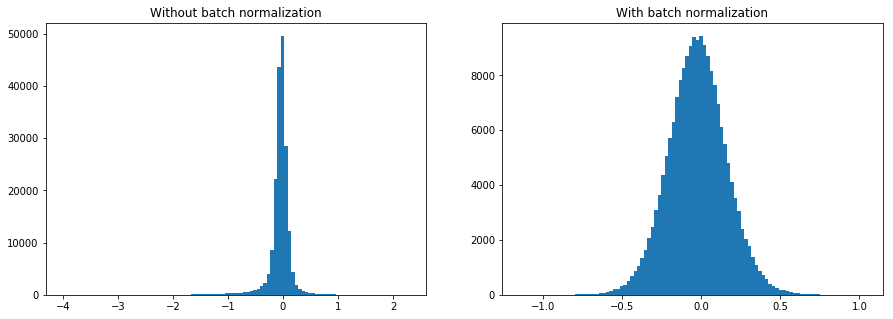

In [11]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
plt.hist(w, bins=100);
plt.title('Without batch normalization')

fig.add_subplot(1, 2, 2)
plt.hist(ww, bins=100);
plt.title('With batch normalization')

Weights are centered around zero with batch normalization, while removing it creates issues for the weights. Indeed, using batch norm not only helps with training the network, but would also be more useful for quantization purposes. 